In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from tabulate import tabulate
from src import camvid
from src import evaluate
from src import predict
from src import segnet
from src.callbacks import PlotMetrics
from src.utils import history_to_results
from src.wrappers import MonteCarlo
%matplotlib inline
plt.style.use('dark_background')

Using TensorFlow backend.


In [2]:
weights_file = 'models/BayesianSegNet-CamVid11.h5'

In [3]:
# the batch size for training the network
batch_size = 8
# the size to crop images to
crop_size = (352, 480)

# Training

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(), 
    target_size=(360, 480), 
    crop_size=crop_size, 
    batch_size=batch_size,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


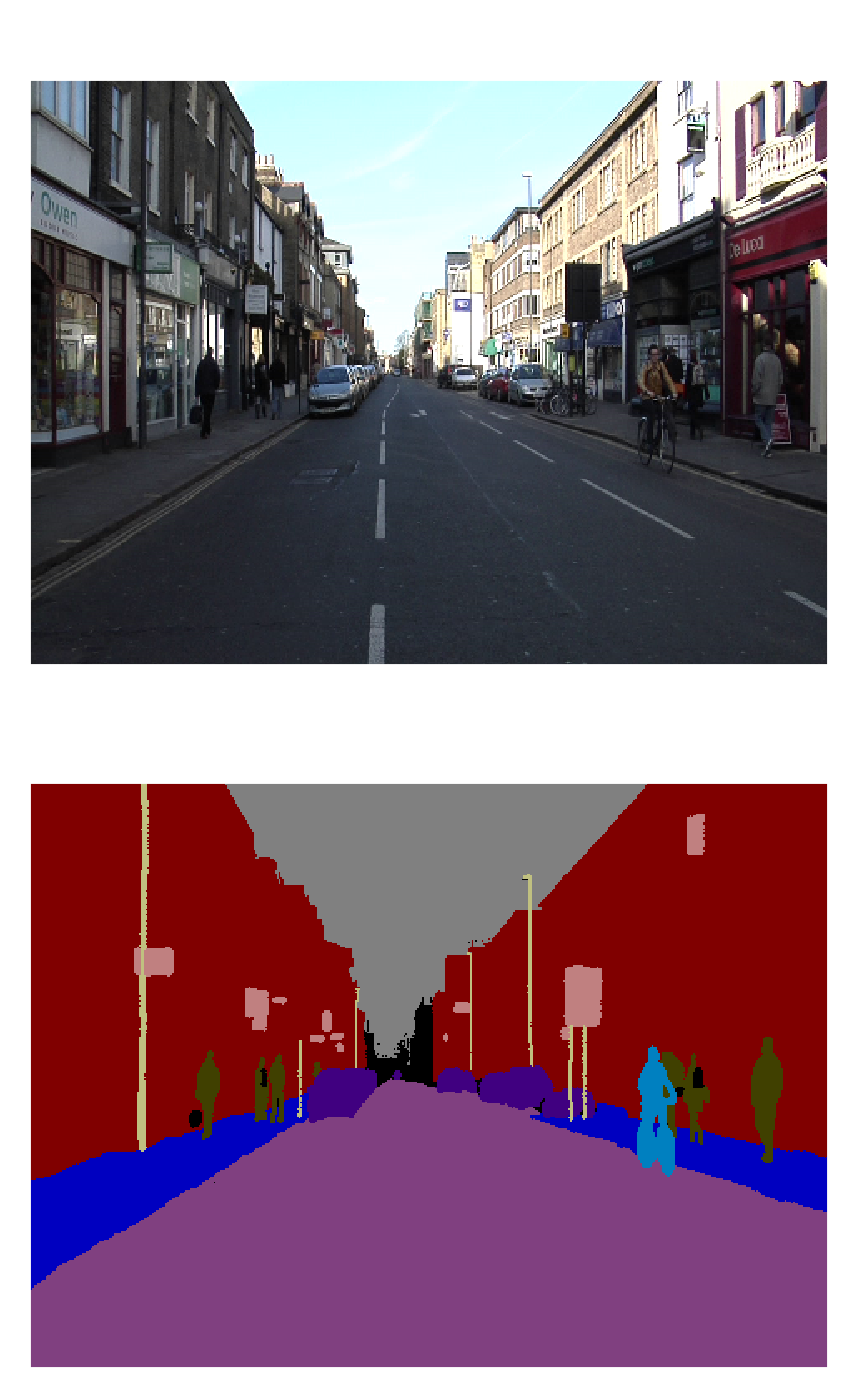

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
model = segnet.build_segnet((*crop_size, 3), camvid11.n, 
    class_weights=camvid11.class_weights,
    dropout_rate=0.5,
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SegNet_input (InputLayer)    (None, 352, 480, 3)       0         
_________________________________________________________________
pixel_norm (Lambda)          (None, 352, 480, 3)       0         
_________________________________________________________________
local_contrast_normalization (None, 352, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 352, 480, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 352, 480, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 352, 480, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 352, 480, 64)      36928     
__________

In [7]:
# # create the callbacks for the training procedure
# callbacks = [
#     EarlyStopping(monitor='loss', patience=50),
#     LearningRateScheduler(lambda _, lr: 0.95 * lr),
#     ModelCheckpoint(weights_file, 
#         monitor='val_categorical_accuracy', 
#         save_best_only=True, 
#         save_weights_only=True, 
#         mode='max'
#     ),
#     PlotMetrics(),
# ]

In [8]:
# # fit the model with the data. divide the steps per epoch by the 
# # batch size (which is 3 in this case)
# history = model.fit_generator(generators['train'],
#     epochs=200,
#     steps_per_epoch=int(367 / batch_size),
#     validation_data=generators['val'],
#     validation_steps=101,
#     callbacks=callbacks,
#     verbose=0
# )

In [9]:
# history_to_results(history)

# Test Metrics

In [10]:
model.load_weights(weights_file)

In [11]:
# wrap the model with the test time Monte Carlo
model = MonteCarlo(model, 40)

In [12]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    label_map=camvid11.label_to_discrete_map
)
metrics

100%|██████████| 233/233 [12:35<00:00,  3.24s/step]


Test
Accuracy                 0.868308
Mean Per Class Accuracy  0.766990
Mean I/U                 0.551621
Bicyclist                0.368256
Building                 0.703801
Car                      0.673174
Column_Pole              0.215822
Fence                    0.380433
Pedestrian               0.341966
Road                     0.887208
Sidewalk                 0.727191
SignSymbol               0.188012
Sky                      0.887993
VegetationMisc           0.693973

In [26]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

| Metric                  |    Value |
|:------------------------|---------:|
| Accuracy                | 0.868308 |
| Mean Per Class Accuracy | 0.76699  |
| Mean I/U                | 0.551621 |
| Bicyclist               | 0.368256 |
| Building                | 0.703801 |
| Car                     | 0.673174 |
| Column_Pole             | 0.215822 |
| Fence                   | 0.380433 |
| Pedestrian              | 0.341966 |
| Road                    | 0.887208 |
| Sidewalk                | 0.727191 |
| SignSymbol              | 0.188012 |
| Sky                     | 0.887993 |
| VegetationMisc          | 0.693973 |


# Qualitative Results

### Train Results

In [13]:
X, y, p, s = predict.predict_epistemic(model, generators['train'], camvid11)

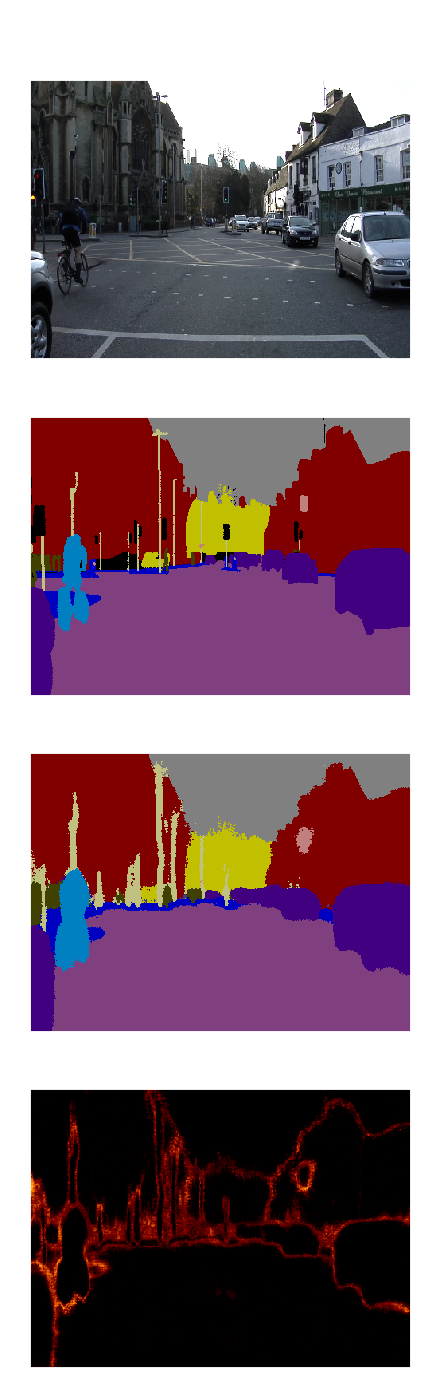

In [14]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

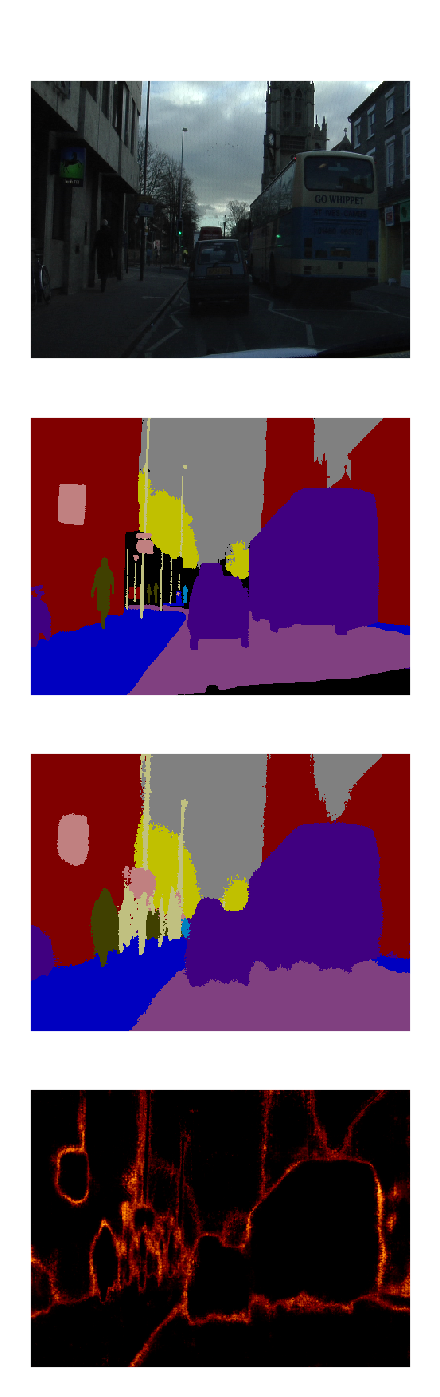

In [15]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], uncertainty=s[1], order=['X', 'y', 'y_pred', 'uncertainty'])

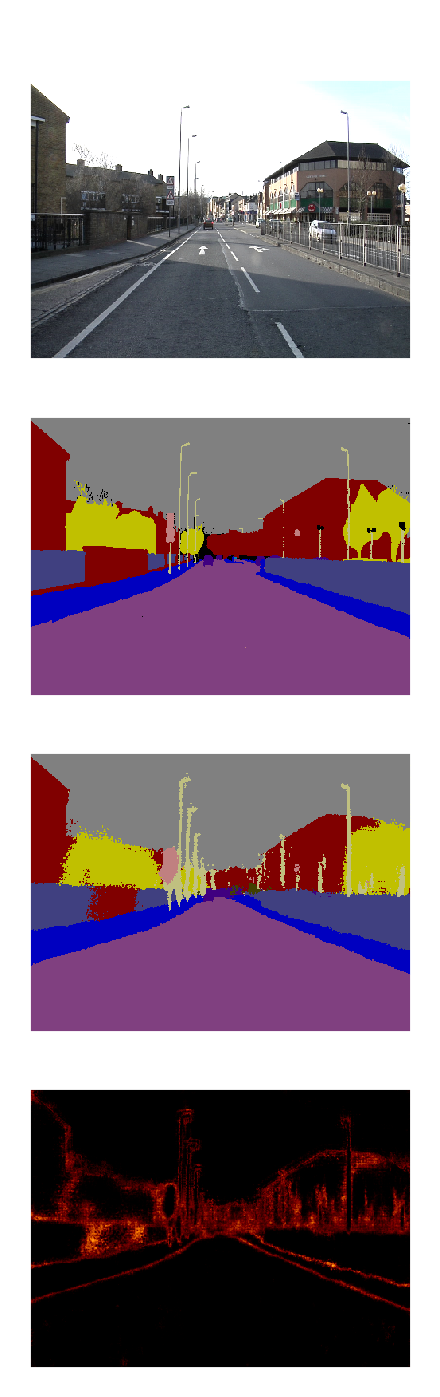

In [16]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], uncertainty=s[2], order=['X', 'y', 'y_pred', 'uncertainty'])

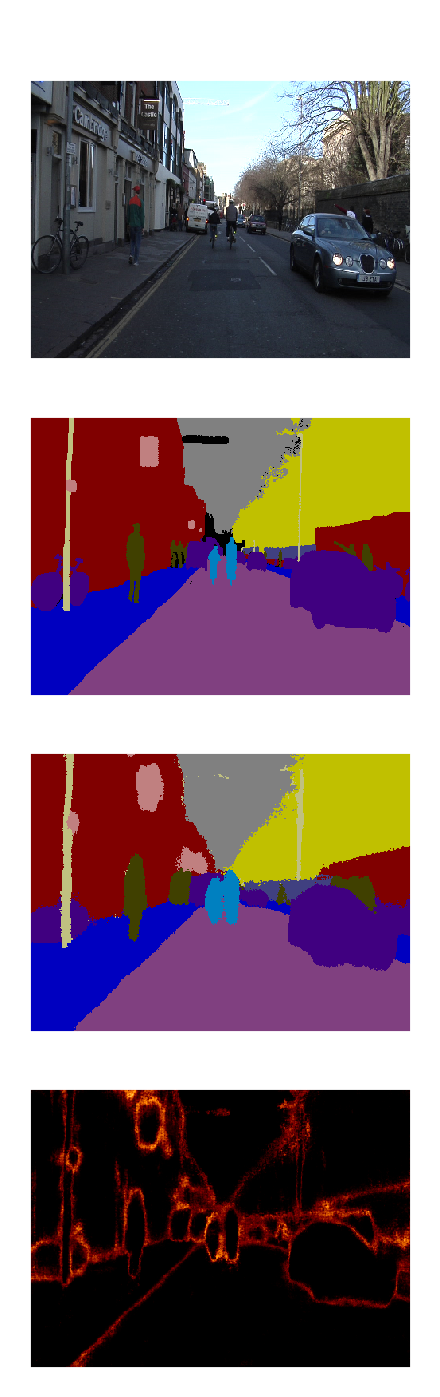

In [17]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3], uncertainty=s[3], order=['X', 'y', 'y_pred', 'uncertainty'])

### Validation Results

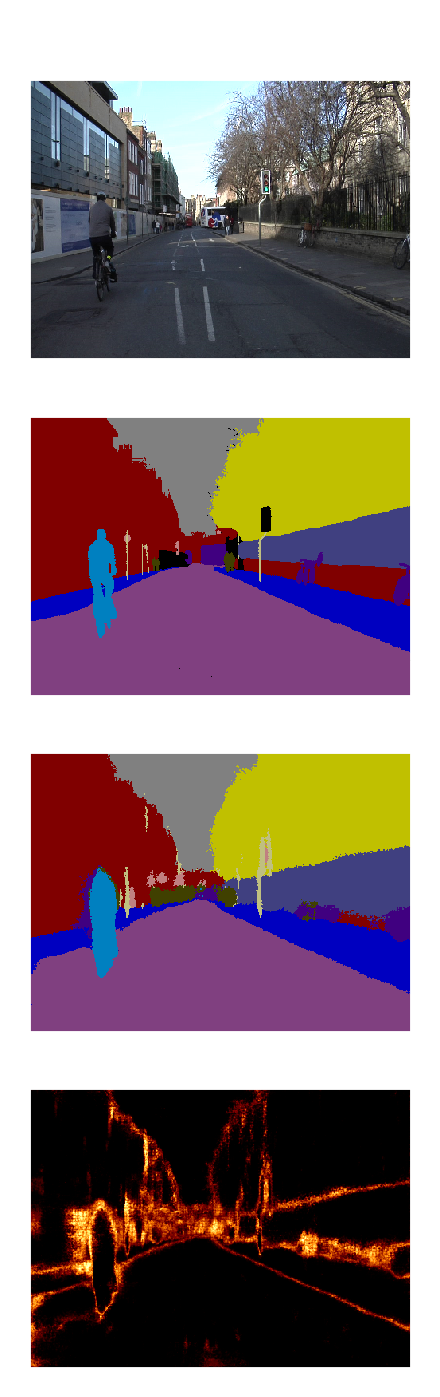

In [18]:
X, y, p, s = predict.predict_epistemic(model, generators['val'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

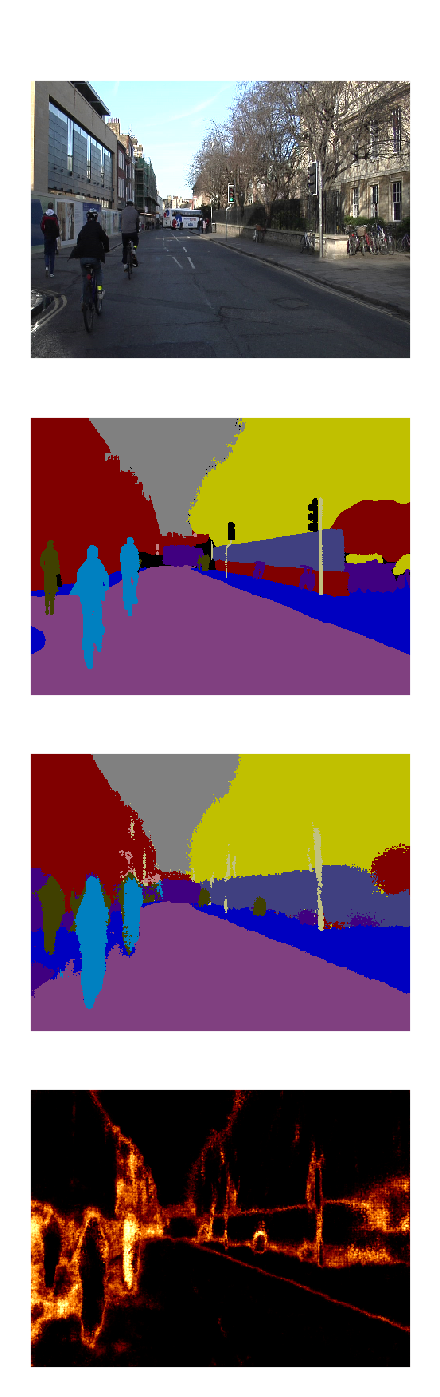

In [19]:
X, y, p, s = predict.predict_epistemic(model, generators['val'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

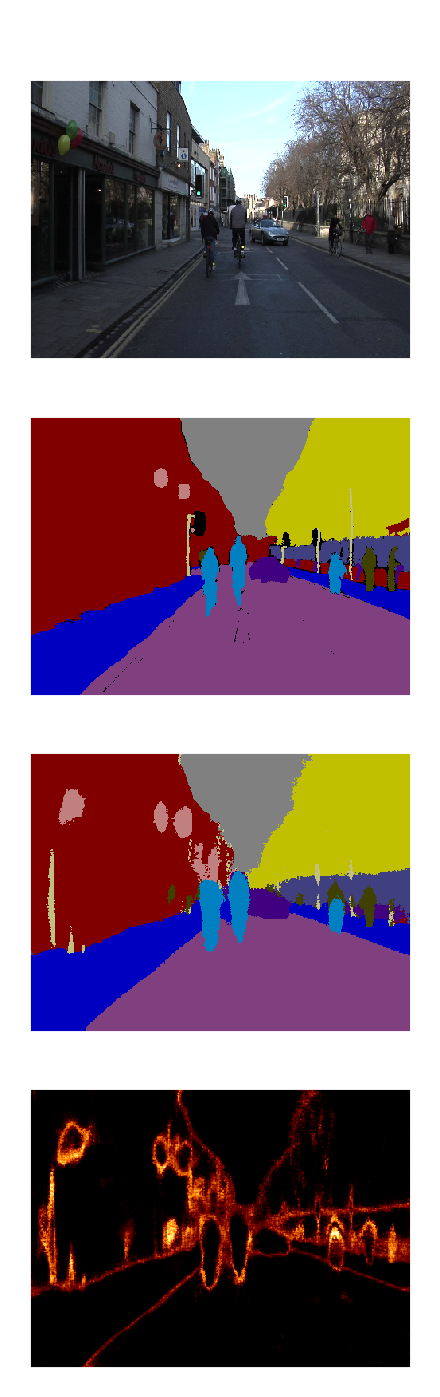

In [20]:
X, y, p, s = predict.predict_epistemic(model, generators['val'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

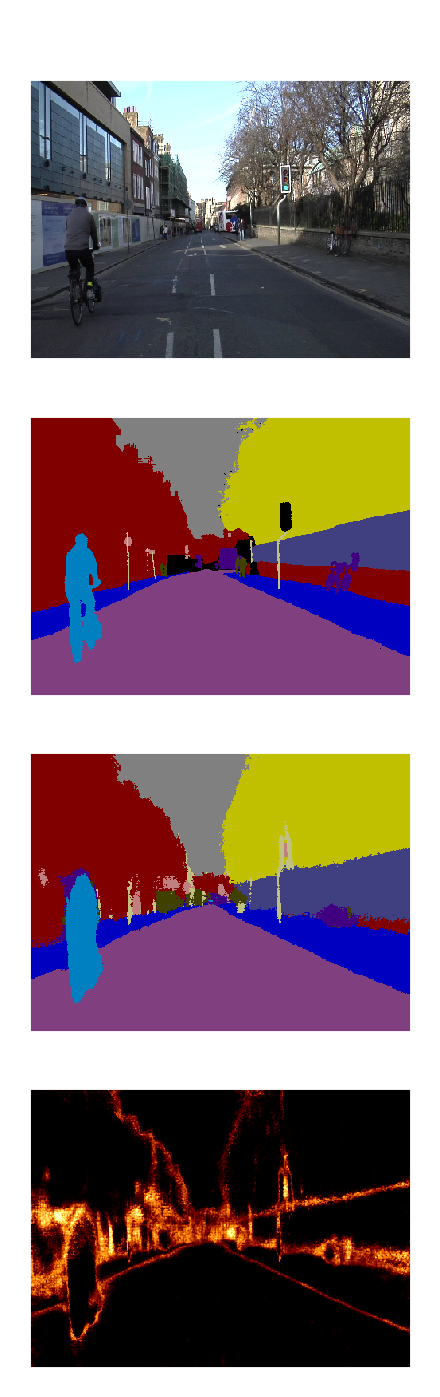

In [21]:
X, y, p, s = predict.predict_epistemic(model, generators['val'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

### Test Results

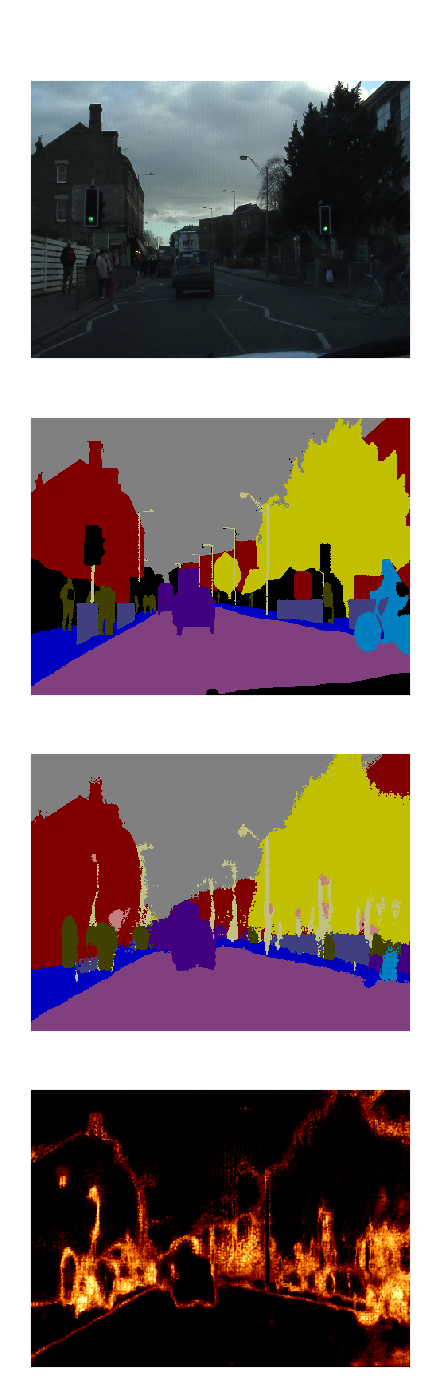

In [22]:
X, y, p, s = predict.predict_epistemic(model, generators['test'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

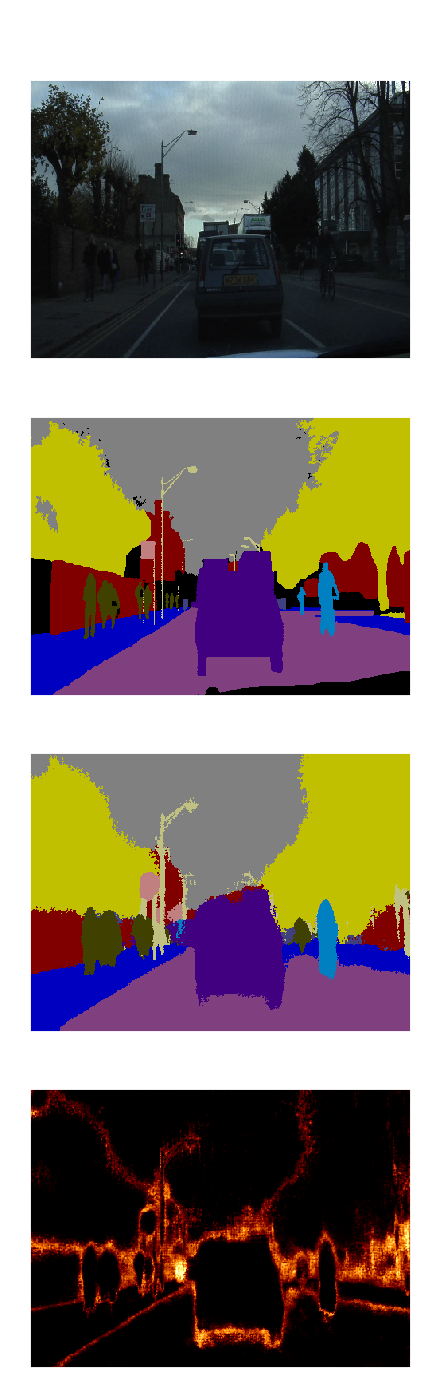

In [23]:
X, y, p, s = predict.predict_epistemic(model, generators['test'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

In [24]:
X, y, p, s = predict.predict_epistemic(model, generators['test'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])

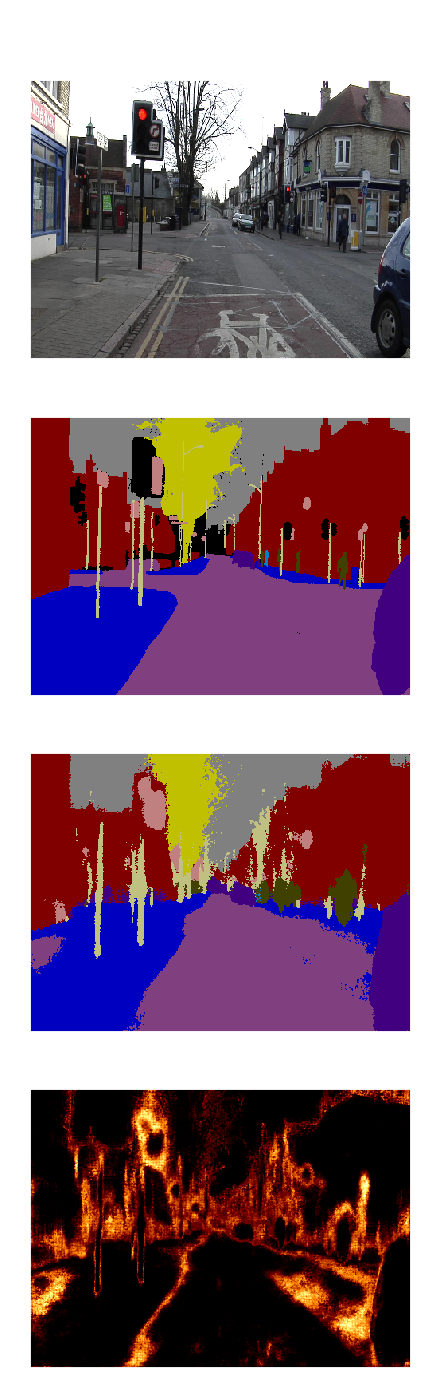

In [25]:
X, y, p, s = predict.predict_epistemic(model, generators['test'], camvid11)
camvid.plot(X=X[0], y=y[0], y_pred=p[0], uncertainty=s[0], order=['X', 'y', 'y_pred', 'uncertainty'])